In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import random 
import cv2

2022-11-13 17:23:20.934318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 17:23:23.597277: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 17:23:28.900722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-13 17:23:28.900979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

In [4]:
data_dir = "../data/data/"

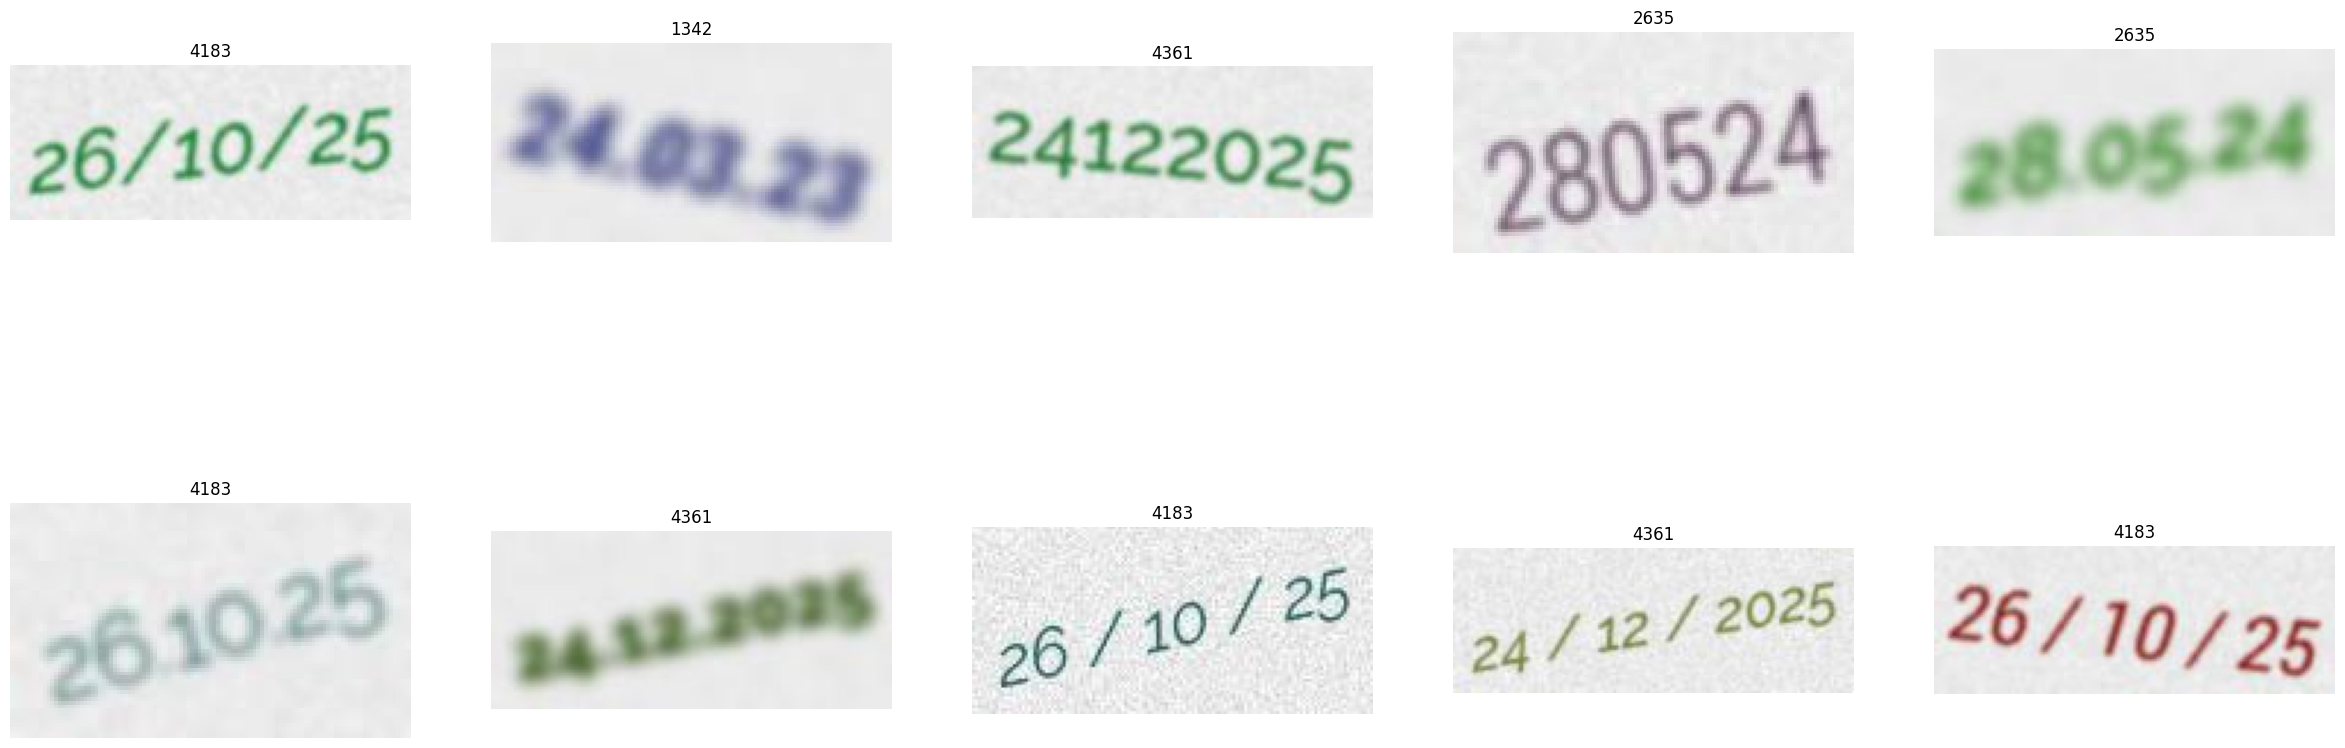

In [5]:
classes = os.listdir(data_dir)

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(data_dir+"/"+classes[i])
    j = random.randint(1,100)                  # getting the image
    image = cv2.imread(data_dir+"/"+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [6]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    rescale = 1./127.5,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
)

In [7]:
BATCH_SIZE = 64
IMG_SIZE = (75, 75)

In [8]:
train_ds = gen.flow_from_directory(
    data_dir,
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = gen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 354240 images belonging to 4428 classes.
Found 88560 images belonging to 4428 classes.


In [9]:
# val_batches = tf.data.experimental.cardinality(val_ds)
# test_ds = val_ds.take(val_batches // 5)
# val_ds = val_ds.skip(val_batches // 5)

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(75,75),
    # layers.experimental.preprocessing.Rescaling(1./127.5 , offset= -1),
])

2022-11-13 17:24:37.900982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/python/3.10.4/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-13 17:24:37.909361: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-13 17:24:37.909416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-337442): /proc/driver/nvidia/version does not exist
2022-11-13 17:24:37.910099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
base_model = tf.keras.applications.InceptionResNetV2(
    input_shape = (75, 75, 3),
    include_top = False,
    weights="imagenet",
)

In [12]:
base_model.trainable = False

In [13]:
checkpoint_path = "expired_date_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [15]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-11-13 17:24:51.226338: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20070400 exceeds 10% of free system memory.
2022-11-13 17:24:51.248088: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20070400 exceeds 10% of free system memory.
2022-11-13 17:24:51.258723: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20070400 exceeds 10% of free system memory.


(64, 1, 1, 1536)


In [16]:
global_avg_layer = layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(64, 1536)


In [17]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [18]:
inputs = layers.Input(shape=(75, 75, 3))
# x = tf.cast(i, tf.float32)
x = data_augmentation(x)
x = preprocess_input(x)
x = tf.keras.layers.Conv2D(filters=3, kernel_size=(1,1), activation='relu')(inputs)
# x = tf.keras.layers.Resizing(height=75, width=75)(x)

x = base_model(x, training=False)
x = global_avg_layer(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4428, activation="softmax")(x)
model = Model(inputs, outputs)

ValueError: Exception encountered when calling layer "resizing" "                 f"(type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing" "                 f"(type Resizing):
  • inputs=tf.Tensor(shape=(), dtype=int32)

In [ ]:
lr = 0.0001
model.compile(
    optimizer=Adam(lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_822 (Conv2D)         (None, 75, 75, 3)         12        
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_6   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 1536)              0         
                                                                 
 dense_12 (Dense)            (None, 4428)              6805

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=train_ds,
    validation_steps=len(train_ds),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "expired_date_classification"),
        checkpoint_callback,
    ]
)

NameError: name 'model' is not defined

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [ ]:
model.save("model.h5")